# Imports :

In [ ]:
!pip install tensorflow_addons

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import keras
from keras.layers import Dense, Conv2D, MaxPool2D,GlobalAveragePooling2D, UpSampling2D, Dropout, Input , Softmax
from keras.activations import sigmoid
from keras.utils import img_to_array
from sklearn.metrics import f1_score,precision_score
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import re


import pandas as pd
from PIL import Image

from tensorflow.python.client import device_lib



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Global Parameters :

In [ ]:
SIZE = 256  # Size of image for input model
nbr_epoch_train_enco= 200
nbr_epoch_train_autoenco= 1000

learning_rate_enco = 0.0001
learning_rate_autoenco =  0.0001
mainpath = ''   # project directory

# Pré-entrainement encodeur :

## Load CelebA dataset :

In [ ]:
image_path = mainpath + 'archive/img_align_celeba/img_align_celeba'
df_attr = pd.read_csv(mainpath+'archive/list_attr_celeba.csv',nrows=3000) #nrows: max =3000 (ram) ou 8000 (data)
df_attr.head()
df_attr.replace(-1,0,inplace=True)
df_attr.head()
column_names = list(df_attr.columns.values)

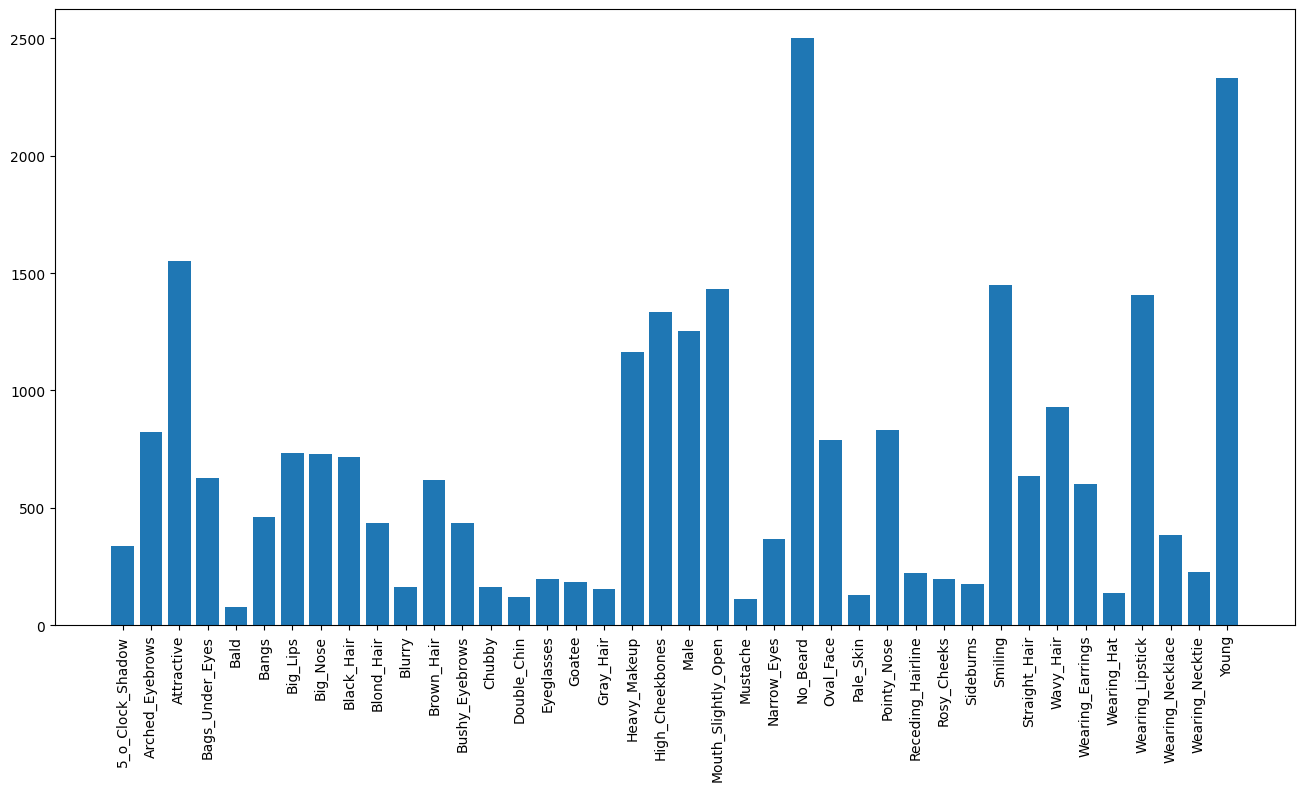

In [ ]:
arr=pd.DataFrame(df_attr.iloc[:,1:].sum(axis=0))
arr.columns=['labels']
arr.sort_values(by='labels',ascending=False)
plt.figure(figsize=(16,8))
plt.bar(arr.index,arr['labels'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
nbr_echant,_=df_attr.shape
x=df_attr.iloc[:,1:].sum(axis=0)
weigths=[]
list_indx=[]
for i in range(0,len(column_names)-1):
  weigths.append(x[i]/nbr_echant)
  list_indx.append(i)
class_weigths=dict(zip(list_indx, weigths))

In [ ]:
#Relancer si tourne en boucle
img_array=[]
attr_array=[]
for index, row in tqdm(df_attr.iterrows()):
      list_val=[]
      for attr in column_names:
        if attr=='image_id':
          image = cv2.imread(image_path + '/' + row[attr],1)

          # as opencv load image in bgr format converting it to rgb
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

          # resizing images
          image = cv2.resize(image, (SIZE, SIZE))

          # normalizing image
          image = image.astype('float32') / 255.0

          #appending normal normal image
          img_array.append(img_to_array(image))
        else:
          list_val.append(row[attr])
      attr_array.append(np.array(list_val))




3000it [13:58,  3.58it/s]


In [ ]:
del df_attr
del x
del arr

In [ ]:
len_array=len(img_array)
img_array = np.reshape(img_array, (len_array,SIZE,SIZE,3))
attr_array= np.reshape(attr_array, (len_array,40))

In [ ]:
def imshow(images,attr,idx:int):
    plt.imshow(images[idx])
    labels=column_names[1:]
    att=attr[idx]
    labels=[label for label,a in list(zip(labels,att)) if a==1]
    plt.xlabel("\n".join(labels))
    plt.show()

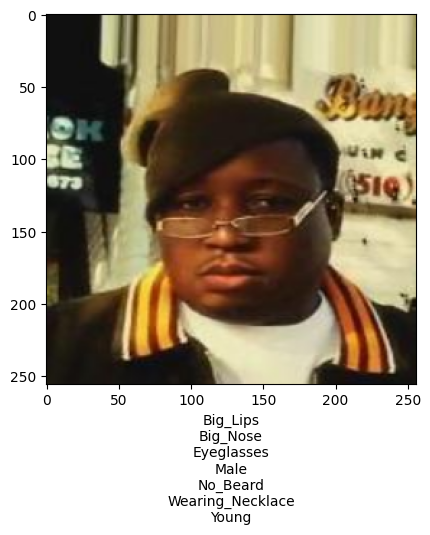

In [ ]:
imshow(img_array,attr_array,481)

In [ ]:
test_ratio=0.01
len_train=int((1-test_ratio)*len_array)

train_image=img_array[:len_train]
train_att=attr_array[:len_train]

test_image=img_array[len_train:]
test_att=attr_array[len_train:]

In [ ]:
train_image.shape,test_image.shape

((2970, 256, 256, 3), (30, 256, 256, 3))

In [ ]:
train_att.shape,test_att.shape

((2970, 40), (30, 40))

In [ ]:
del img_array
del attr_array

## Encodeur :

In [ ]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="images")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_1")(encoder_input)
x = MaxPool2D(pool_size = (2,2), name="encoder_2")(x)

x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid', name="encoder_3")(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same', name="encoder_4")(x)
x = MaxPool2D(pool_size = (2,2), name="encoder_5")(x)

x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_6")(x)
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_7")(x)
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_8")(x)
encoder = tf.keras.Model(encoder_input, encoder_output)

In [ ]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 encoder_2 (MaxPooling2D)    (None, 128, 128, 16)      0         
                                                                 
 encoder_3 (Conv2D)          (None, 63, 63, 32)        4640      
                                                                 
 encoder_4 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 encoder_5 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 encoder_6 (Conv2D)          (None, 16, 16, 128)       73856 

## Classificateur :

In [ ]:
nbr_classes=40
classificateur_input = GlobalAveragePooling2D()(encoder_output)
classificateur_output = Dense(nbr_classes,activation="sigmoid")(classificateur_input)

model_classificateur= keras.Model(encoder_input, classificateur_output)
model_classificateur.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 encoder_2 (MaxPooling2D)    (None, 128, 128, 16)      0         
                                                                 
 encoder_3 (Conv2D)          (None, 63, 63, 32)        4640      
                                                                 
 encoder_4 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 encoder_5 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 encoder_6 (Conv2D)          (None, 16, 16, 128)       7385

## Entrainement sur celeba :

In [ ]:
with tf.device('/device:GPU:0'):
  model_classificateur.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_enco),
                              loss = 'binary_crossentropy',
                              metrics = [tfa.metrics.F1Score(num_classes=nbr_classes,average='weighted',threshold=0.5)])

  history  = model_classificateur.fit(train_image,train_att, validation_split=0.1,batch_size=32 ,epochs = nbr_epoch_train_enco, verbose = 1,shuffle=True,class_weight=class_weigths)

Epoch 1/200
84/84 [==============================] - 24s 56ms/step - loss: 0.1394 - f1_score: 0.3176 - val_loss: 0.4542 - val_f1_score: 0.3312
Epoch 2/200
84/84 [==============================] - 3s 40ms/step - loss: 0.1222 - f1_score: 0.3110 - val_loss: 0.4408 - val_f1_score: 0.2285
Epoch 3/200
84/84 [==============================] - 4s 42ms/step - loss: 0.1211 - f1_score: 0.2989 - val_loss: 0.4364 - val_f1_score: 0.3600
Epoch 4/200
84/84 [==============================] - 3s 41ms/step - loss: 0.1202 - f1_score: 0.3048 - val_loss: 0.4362 - val_f1_score: 0.3111
Epoch 5/200
84/84 [==============================] - 3s 41ms/step - loss: 0.1194 - f1_score: 0.3190 - val_loss: 0.4263 - val_f1_score: 0.3100
Epoch 6/200
84/84 [==============================] - 3s 41ms/step - loss: 0.1188 - f1_score: 0.3343 - val_loss: 0.4240 - val_f1_score: 0.2967
Epoch 7/200
84/84 [==============================] - 4s 43ms/step - loss: 0.1180 - f1_score: 0.3357 - val_loss: 0.4209 - val_f1_score: 0.3423
Epoch

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])


In [ ]:
print(history.history['f1_score'])

[0.31398600339889526, 0.2897939383983612, 0.30479171872138977, 0.30547210574150085, 0.296935498714447, 0.31037241220474243, 0.312274307012558, 0.32701560854911804, 0.3428632915019989, 0.35672616958618164, 0.3494914174079895, 0.36153072118759155, 0.3646754026412964, 0.3678973317146301, 0.37818554043769836, 0.39197641611099243, 0.3942892551422119, 0.40752995014190674, 0.40968993306159973, 0.4154021143913269, 0.4144577980041504, 0.4181819558143616, 0.4235965609550476, 0.4260295331478119, 0.4294281601905823, 0.43215441703796387, 0.4352932572364807, 0.4340152144432068, 0.4356369376182556, 0.4394952654838562, 0.4404188394546509, 0.4419742822647095, 0.44507360458374023, 0.4475707709789276, 0.4402216672897339, 0.4489818513393402, 0.45165425539016724, 0.45211678743362427, 0.45393556356430054, 0.45440375804901123, 0.45422402024269104, 0.4600059986114502, 0.46519550681114197, 0.4628612995147705, 0.4655138850212097, 0.4692394733428955, 0.4681784212589264, 0.47236311435699463, 0.47223150730133057, 

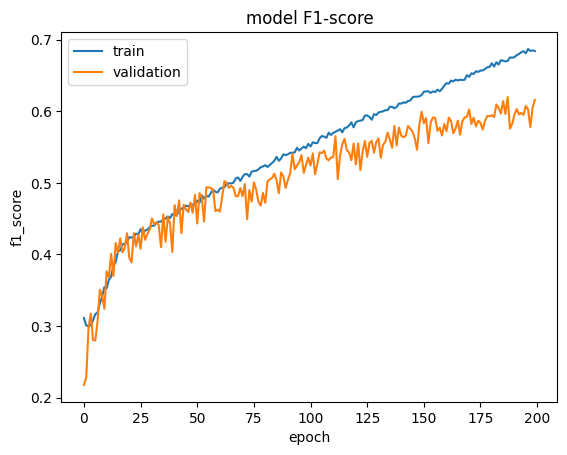

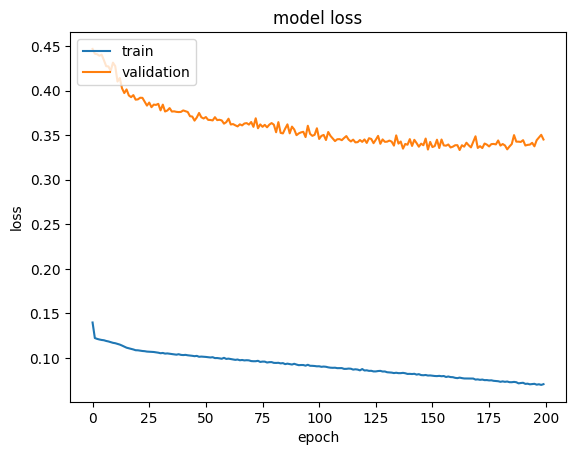

In [ ]:
# summarize history for f1-score
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model F1-score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
del train_image
del train_att

In [ ]:
with tf.device('/device:GPU:0'):
  prediction_on_test_data = model_classificateur.evaluate(test_image, test_att)
  print("Loss: ", prediction_on_test_data[0])
  print("F1-score: ", np.round(prediction_on_test_data[1] * 100,1))

1/1 [==============================] - 0s 490ms/step - loss: 0.3682 - f1_score: 0.5663
Loss:  0.36816850304603577
F1-score:  56.6


In [ ]:
def show_rslt(images,attr,prediction,indx):
    plt.imshow(images[indx])
    labels=column_names[1:]
    prediction=prediction[indx]
    att=attr[indx]
    targ=[label for label,a in list(zip(labels,att)) if a==1]
    preds=[label for label,a in list(zip(labels,prediction)) if a>.5]
    plt.xlabel("\n".join(targ) +"\n \n Prédiction :\n"+ "\n".join(preds))
    plt.show()

In [ ]:
with tf.device('/device:GPU:0'):
  pred=model_classificateur.predict(test_image)

1/1 [==============================] - 0s 32ms/step


In [ ]:
print(test_image.shape)

(30, 256, 256, 3)


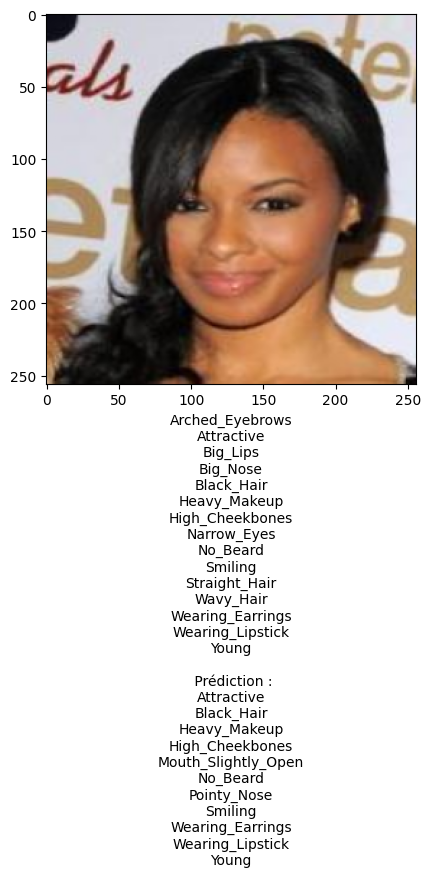

In [ ]:
index=12
show_rslt(test_image,test_att,pred,index)

In [ ]:
#model_classificateur.save(mainpath+'savemodels/model_classificateur')

# Load Sketch dataset :

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


image_path = mainpath +'dataset/photos'
img_array = []

sketch_path = mainpath + 'dataset/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)

    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resizing images
    image = cv2.resize(image, (SIZE, SIZE))

    # normalizing image
    image = image.astype('float32') / 255.0

    #appending normal normal image
    img_array.append(img_to_array(image))
    # Image Augmentation

    # brightness
    img1 = tf.image.random_brightness(image,max_delta=0.5)
    img_array.append(img_to_array(img1))
    # contrast
    temp_img= tf.convert_to_tensor(image)
    img2 = tf.image.random_contrast(image,lower=0.1,upper=1.0)
    img_array.append(img_to_array(img2))
    # saturation
    img3 = tf.image.random_saturation(image,lower=0.1,upper=1.0)
    img_array.append(img_to_array(img3))
    # hue
    img4 = tf.image.random_hue(image,max_delta=0.5)
    img_array.append(img_to_array(img4))



for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)

    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resizing images
    image = cv2.resize(image, (SIZE, SIZE))

    # normalizing image
    image = image.astype('float32') / 255.0
    # appending normal sketch image

    for i in range(0,5):
      sketch_array.append(img_to_array(image)) # one for each image augmentation + original image


FileNotFoundError: ignored

In [ ]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

In [ ]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)

    plt.show()

In [ ]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])

In [ ]:
train_sketch_image = sketch_array[:900]
train_image = img_array[:900]
test_sketch_image = sketch_array[900:]
test_image = img_array[900:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

# Entrainement sur sketch

## Chargement encodeur préentrainé :

In [ ]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="images")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_1")(encoder_input)
x = MaxPool2D(pool_size = (2,2), name="encoder_2")(x)

x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid', name="encoder_3")(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same', name="encoder_4")(x)
x = MaxPool2D(pool_size = (2,2), name="encoder_5")(x)

x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_6")(x)
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_7")(x)
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_8")(x)
encoder = tf.keras.Model(encoder_input, encoder_output)

In [ ]:
model_classificateur = keras.models.load_model(mainpath+'savemodels/model_classificateur')

In [ ]:
list_layer_encod=['encoder_1','encoder_2','encoder_3','encoder_4','encoder_5','encoder_6','encoder_7','encoder_8']

In [ ]:
#update weights
for layer_name in list_layer_encod:
  encoder.get_layer(layer_name).set_weights(model_classificateur.get_layer(layer_name).get_weights())

In [ ]:
encoder.trainable = False #freeze weigths

## Décodeur :

In [ ]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="images")
x = encoder(encoder_input,training=False)
x = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_1')(x)
x = UpSampling2D(size = (2,2),name='decoder_2')(x)
x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_3')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_4')(x)
x = UpSampling2D(size = (2,2),name='decoder_5' )(x)

x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_7')(x)
x = UpSampling2D(size = (2,2) ,name='decoder_8' )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_9')(x)
x = UpSampling2D(size = (2,2) ,name='decoder_10')(x)

x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_11')(x)
decoder_output = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_12')(x)

# # final model
model = keras.Model(encoder_input, decoder_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, 16, 16, 512)       1572768   
                                                                 
 decoder_1 (Conv2D)          (None, 16, 16, 512)       2359808   
                                                                 
 decoder_2 (UpSampling2D)    (None, 32, 32, 512)       0         
                                                                 
 decoder_3 (Conv2D)          (None, 32, 32, 256)       1179904   
                                                                 
 decoder_4 (Conv2D)          (None, 32, 32, 128)       295040    
                                                                 
 decoder_5 (UpSampling2D)    (None, 64, 64, 128)       0   

## Entrainement Autoencoder :

In [ ]:
with tf.device('/device:GPU:0'):
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_autoenco), loss = 'mean_absolute_error',
                metrics = ['acc'])

  history=model.fit(train_image, train_sketch_image, epochs = nbr_epoch_train_autoenco, verbose = 1,validation_split=0.1 )

Epoch 1/1000
26/26 [==============================] - 27s 371ms/step - loss: 0.3661 - acc: 0.3381 - val_loss: 0.2135 - val_acc: 0.2116
Epoch 2/1000
26/26 [==============================] - 4s 166ms/step - loss: 0.1873 - acc: 0.2417 - val_loss: 0.1702 - val_acc: 0.2779
Epoch 3/1000
26/26 [==============================] - 4s 164ms/step - loss: 0.1579 - acc: 0.2644 - val_loss: 0.1556 - val_acc: 0.2703
Epoch 4/1000
26/26 [==============================] - 4s 173ms/step - loss: 0.1447 - acc: 0.2639 - val_loss: 0.1531 - val_acc: 0.2756
Epoch 5/1000
26/26 [==============================] - 4s 163ms/step - loss: 0.1383 - acc: 0.2742 - val_loss: 0.1583 - val_acc: 0.2716
Epoch 6/1000
26/26 [==============================] - 4s 167ms/step - loss: 0.1375 - acc: 0.2723 - val_loss: 0.1365 - val_acc: 0.2898
Epoch 7/1000
26/26 [==============================] - 4s 167ms/step - loss: 0.1249 - acc: 0.2875 - val_loss: 0.1342 - val_acc: 0.2890
Epoch 8/1000
26/26 [==============================] - 4s 166m

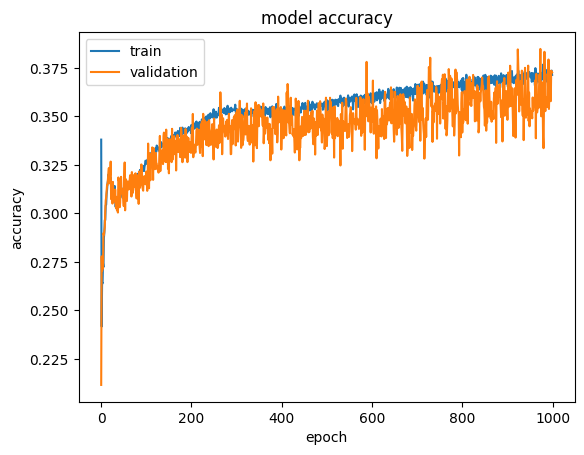

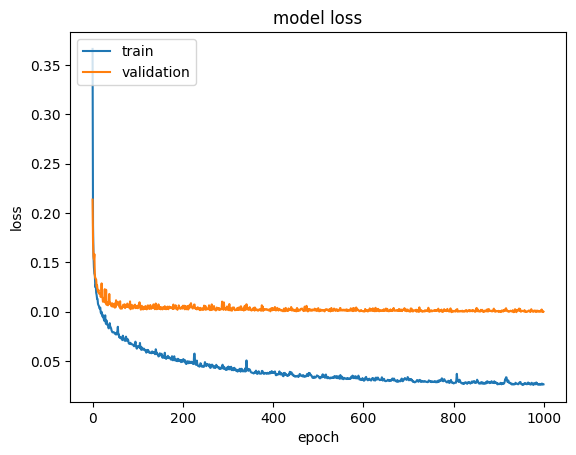

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
with tf.device('/device:GPU:0'):
  prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

2/2 [==============================] - 1s 883ms/step - loss: 0.0856 - acc: 0.3792
Loss:  0.08555574715137482
Accuracy:  37.9


In [ ]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

In [ ]:
ls = [i for i in range(0,30,4)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)

In [ ]:
#model.save(mainpath+'savemodels/model_first_train')

# Ré-entrainement sur sketch avec encoder unfreeze :

Abandon de cette idée, les performances diminuent en relançant un entrainement entier du modèle et pas juste du décodeur.

## Chargement du modèle :

In [ ]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="images")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_1")(encoder_input)
x = MaxPool2D(pool_size = (2,2), name="encoder_2")(x)

x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid', name="encoder_3")(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same', name="encoder_4")(x)
x = MaxPool2D(pool_size = (2,2), name="encoder_5")(x)

x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_6")(x)
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_7")(x)
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same', name="encoder_8")(x)
encoder = tf.keras.Model(encoder_input, encoder_output)

In [ ]:
model_classificateur = keras.models.load_model(mainpath+'savemodels/model_classificateur')

In [ ]:
list_layer_encod=['encoder_1','encoder_2','encoder_3','encoder_4','encoder_5','encoder_6','encoder_7','encoder_8']
list_layer_decod=['decoder_1','decoder_2','decoder_3','decoder_4','decoder_5','decoder_7','decoder_8','decoder_9','decoder_10','decoder_11','decoder_12',]

In [ ]:
#update weights
for layer_name in list_layer_encod:
  encoder.get_layer(layer_name).set_weights(model_classificateur.get_layer(layer_name).get_weights())

In [ ]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="images")
x = encoder(encoder_input)
x = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_1')(x)
x = UpSampling2D(size = (2,2),name='decoder_2')(x)
x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_3')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_4')(x)
x = UpSampling2D(size = (2,2),name='decoder_5' )(x)

x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_7')(x)
x = UpSampling2D(size = (2,2) ,name='decoder_8' )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_9')(x)
x = UpSampling2D(size = (2,2) ,name='decoder_10')(x)

x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_11')(x)
decoder_output = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same',name='decoder_12')(x)

# # final model
model = keras.Model(encoder_input, decoder_output)
model.summary()

In [ ]:
auto_enco = keras.models.load_model(mainpath+'savemodels/model_first_train')

In [ ]:
#update weights
for layer_name in list_layer_decod:
  model.get_layer(layer_name).set_weights(auto_enco.get_layer(layer_name).get_weights())

In [ ]:
with tf.device('/device:GPU:0'):
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_autoenco*0.001), loss = 'mean_absolute_error',
                metrics = ['acc'])

  #model.fit(train_image, train_sketch_image, epochs = nbr_epoch_train_autoenco, verbose = 1 )
  history=model.fit(train_image, train_sketch_image, epochs = 500, verbose = 1,validation_split=0.1 )

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
with tf.device('/device:GPU:0'):
  prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

In [ ]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

In [ ]:
ls = [i for i in range(0,30,4)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)

In [ ]:
model.save(mainpath+'savemodels/autoenco')

# Test :

## Load example from celebA

In [ ]:
image_path = mainpath + 'archive/img_align_celeba/img_align_celeba'
df_attr = pd.read_csv(mainpath+'archive/list_attr_celeba.csv',nrows=30)
df_attr.head()
df_attr.replace(-1,0,inplace=True)
df_attr.head()
column_names = list(df_attr.columns.values)

In [ ]:
#Relancer si tourne en boucle
img_array=[]
for index, row in tqdm(df_attr.iterrows()):
      for attr in column_names:
        if attr=='image_id':
          image = cv2.imread(image_path + '/' + row[attr],1)

          # as opencv load image in bgr format converting it to rgb
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

          # resizing images
          image = cv2.resize(image, (SIZE, SIZE))

          # normalizing image
          image = image.astype('float32') / 255.0

          #appending normal normal image
          img_array.append(img_to_array(image))

30it [00:10,  2.82it/s]


## Model prediction :

In [ ]:
img_array = np.reshape(img_array, (len(img_array),SIZE,SIZE,3))

In [ ]:
auto_encoder = keras.models.load_model(mainpath+'savemodels/model_first_train')

In [ ]:
prediction=auto_encoder.predict(img_array)

1/1 [==============================] - 5s 5s/step


In [ ]:
def show_images(real, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,2,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,2,2)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

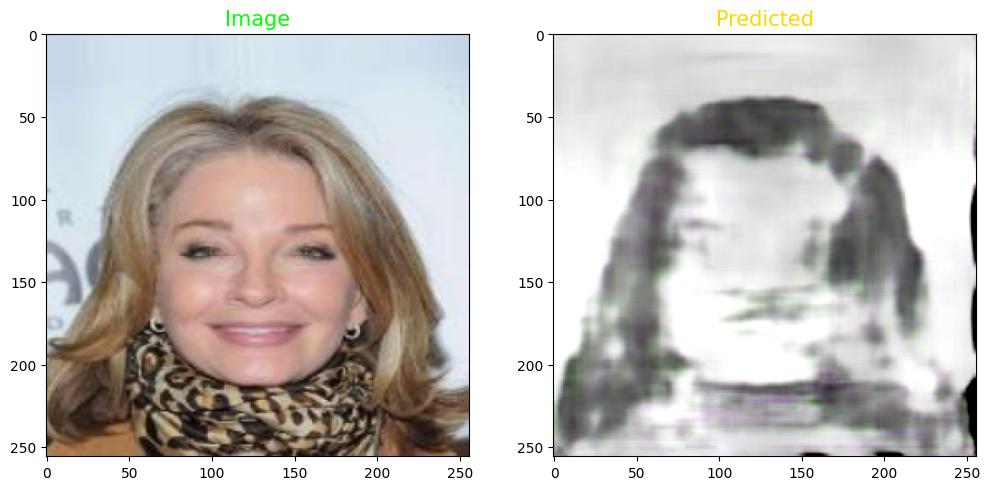

In [ ]:
index=17
show_images(img_array[index],prediction[index])